In [1]:
'''Importação das bibliotecas'''

import pandas as pd
import numpy as np
import nltk
import spacy
import string
import plotly.express as px
from joblib import dump, load
from stop_words import get_stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from enelvo.normaliser import Normaliser

## 1. Importando e tratando os dados

In [2]:
'''Importação dos dados'''
df = pd.read_csv(r'database/dataframe_final.csv')

# dropa os dados nulos
df.dropna(inplace=True)

# transforma todos os comentários para minúsculo
df['Comentário'] = df['Comentário'].str.lower()


def corrige_gramatica(coluna):
    '''Conserta abreviações, potuações e remove emojis'''

    norm = Normaliser(tokenizer='readable', sanitize=True)

    # Usa a função vectorize do NumPy para aplicar a normalização a todos os elementos em uma única chamada
    normalizar = np.vectorize(norm.normalise)

    coluna_normalizada = normalizar(coluna)

    return coluna_normalizada


def remove_pontuacao(review):
    '''# Remove a pontuação dos comentários'''

    review = str(review)
    review = "".join(
        [char for char in review if char not in string.punctuation])
    return review


# corrige a gramática
df['Comentário'] = corrige_gramatica(df['Comentário'])

# Remove a pontuação dos reviews
df['Comentário'] = df['Comentário'].apply(lambda x: remove_pontuacao(x))


def lemmatize_words(text):
    '''Lematiza uma lista de palavras'''

    doc = nlp(text)

    lemmatized_words = [token.lemma_ for token in doc]

    return lemmatized_words


# lematiza a coluna comentário
# Carregando o modelo em português do Brasil do spaCy
nlp = spacy.load("pt_core_news_sm")

df['Comentário'] = df['Comentário'].apply(
    lambda x: " ".join(lemmatize_words(x)))

df.index = np.arange(df.shape[0])

def avalia_nota(x):
    '''Avalia a nota e retorna a classificação do NPS'''

    if x >= 9:
        classificacao = 'Promotor'

    elif x == 7 or x == 8:
        classificacao = 'Neutro'

    else:
        classificacao = 'Detrator'

    return classificacao


df['TARGET'] = df['Nota'].apply(lambda x: avalia_nota(x))

df = df[df['Comentário'].isna() == False]

df.drop_duplicates(keep='last', inplace=True, ignore_index=True)

print('df.head()')
print(df.head())

df.head()
                                          Comentário  Nota    TARGET
0  e um cartão que não falhar em o hora que o gen...    10  Promotor
1         ter haver ano e você não aumentar o limite     0  Detrator
2                           o limite ser muito pouco     7    Neutro
3  preço alto e promoção realizar em dia impropri...     9  Promotor
4  não estar satisfeita com o cartão pois o limit...     1  Detrator


## 2. Avaliando os dados

### 2.1 Avaliando a distribuição dos dados

In [3]:
px.bar(df.groupby('Nota').count()['Comentário'], text_auto=True)
# note que a maioria dos clientes dá nota 10

In [4]:
px.bar(df.groupby('TARGET').count()['Comentário'],  text_auto=True)
# Note que a maioria dos comentários são de clientes é promotores ou detratores

In [5]:
# avaliando a distribuição de detrator, neutros e promotores em %
px.bar(round(df.groupby('TARGET').count()[
       'Comentário']/df.shape[0], 2),  text_auto=True)
# Note que a maioria dos comentários são de clientes é promotores ou detratores

In [6]:
# avaliando a correlação entre a quantidade de palavras do comentário e a nota
df['Qtd_de_palavras'] = [len(x) for x in df['Comentário']]
df[['Nota', 'Qtd_de_palavras']].corr().round(2)

# perceba que existe uma correlação entre a quantidade de palavras do comentário e a nota. Quanto menor a nota, maior o comentário.
# Isto pode ser explicado pois um cliente insatisfeito geralmente descreve com mais detalhes o porquê de estar instatisfeito

,Nota,Qtd_de_palavras
Nota,1.00,-0.26
Qtd_de_palavras,-0.26,1.00


In [7]:
# avaliando a relação entre a quantidade de palavras, nota e o target
px.scatter(df, x='Qtd_de_palavras', y='Nota', color="TARGET",
           color_continuous_scale=["red", "green", "blue"])

In [8]:
# avaliando a relação entre a quantidade de palavras e o target
px.histogram(df[df['Qtd_de_palavras']<=200], x='Qtd_de_palavras', color="TARGET", facet_col='TARGET')

In [9]:
px.scatter(df, x='Nota', size='Qtd_de_palavras',
              y='Qtd_de_palavras', color='TARGET')

### 2.2. Avaliando o vocabulário

In [10]:
# stopWords = get_stop_words('portuguese')
stopWords = nltk.corpus.stopwords.words('portuguese')

vectorizer = CountVectorizer(stop_words=stopWords)
bag_of_words = vectorizer.fit_transform(df['Comentário'].tolist())

print(f'Tamanho do vocabulário: {len(vectorizer.vocabulary_)}\n')
print(f'Aparições por palavra: {vectorizer.vocabulary_}\n')

# 5 elementos com os maiores valores
maiores_elementos = dict(sorted(
    vectorizer.vocabulary_.items(), key=lambda item: item[1], reverse=True)[:5])

# 5 elementos com os menores valores
menores_elementos = dict(
    sorted(vectorizer.vocabulary_.items(), key=lambda item: item[1])[:5])

print("As 5 palavras com mais aparições:")
print(maiores_elementos, '\n')

print("As 5 palavras com menos aparições:")
print(menores_elementos, '\n')

Tamanho do vocabulário: 2196

Aparições por palavra: {'cartão': 462, 'falhar': 983, 'hora': 1127, 'gente': 1079, 'precisar': 1662, 'ter': 2019, 'ano': 225, 'aumentar': 328, 'limite': 1285, 'pouco': 1647, 'preço': 1691, 'alto': 200, 'promoção': 1717, 'realizar': 1781, 'dia': 758, 'improprio': 1155, 'compra': 556, 'geralmente': 1083, 'ocorrer': 1475, 'final': 1021, 'mês': 1426, 'aonde': 242, 'ficar': 1014, 'difícil': 772, 'fazer': 1003, 'gostar': 1092, 'principalmente': 1695, 'setor': 1927, 'grão': 1106, 'carne': 451, 'satisfeita': 1897, 'pois': 1615, 'vista': 2161, 'útil': 2195, 'poder': 1612, 'comprar': 559, 'qualquer': 1747, 'estabelecimento': 928, 'bom': 398, 'amo': 216, 'anuidade': 237, 'todo': 2035, 'pagar': 1524, 'aplicativo': 252, 'acompanhar': 131, 'benéfico': 379, 'nenhum': 1443, 'ir': 1215, 'cancelar': 441, 'sempre': 1910, 'propaganda': 1718, 'enganar': 883, 'facilidade': 976, 'porque': 1627, 'cerco': 484, 'fico': 1015, 'feliz': 1013, 'usar': 2088, 'dever': 750, 'melhorar': 13

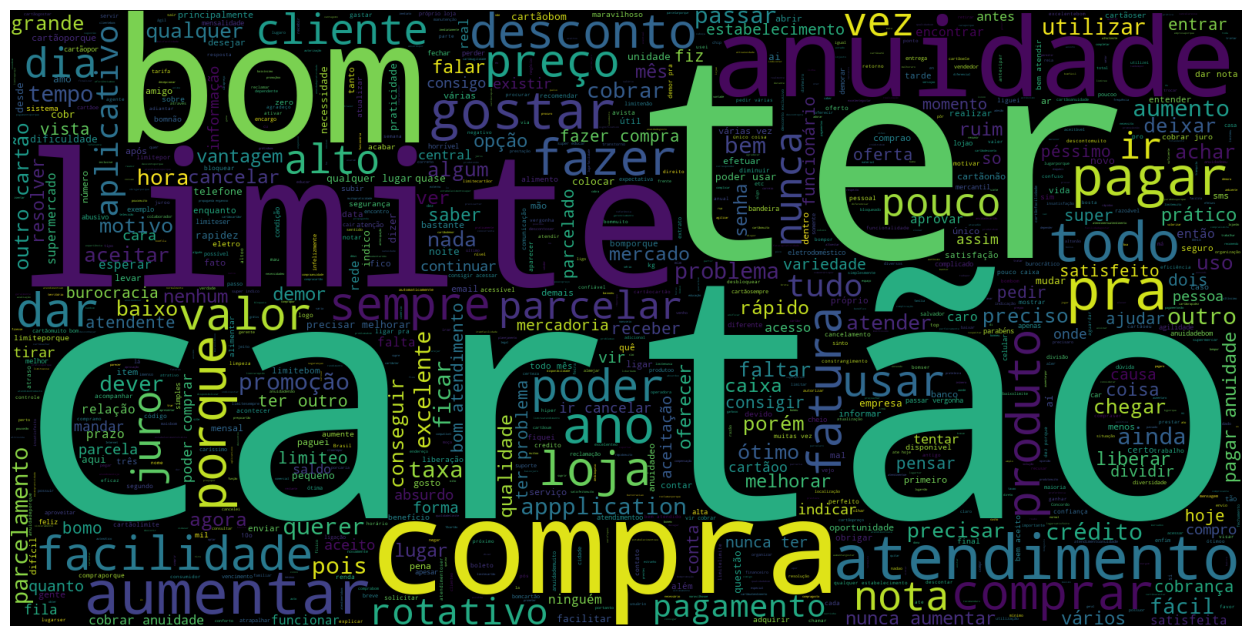

In [11]:
# juntando todos os comentários para construir a wordcloud
todos_os_comentarios = "".join(comentario for comentario in df['Comentário'])

# instanciando a wordcloud
wordcloud = WordCloud(stopwords=stopWords,
                      background_color='black', width=1600,
                      height=800, max_words=1000,  max_font_size=500,
                      min_font_size=1).generate(todos_os_comentarios)  # mask=mask,


# exibindo a wordcloud
fig, ax = plt.subplots(figsize=(16, 8))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wordcloud)
plt.savefig('images/NPS_wordcloud.png')

## 3. Treinando o modelo

In [12]:
# Dividindo os dados em conjunto de treinamento e conjunto de teste
x = df['Comentário'].astype('str')
y = df['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=30, stratify=y)

# instanciando e treinando o CountVectorizer
vectorizer = CountVectorizer(analyzer="word", stop_words=stopWords)
X_train_vectorizer = vectorizer.fit_transform(X_train)
X_test_vectorizer = vectorizer.transform(X_test)

# instanciando o modelo
model = MultinomialNB()

# treinando o modelo nos dados de treinamento
model.fit(X_train_vectorizer, y_train)

# salvando o modelo
dump((model, X_train_vectorizer, vectorizer), 'models/model.joblib')

# fazendo as previsões no conjunto de teste
y_pred = model.predict(X_test_vectorizer)

# avaliando o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'\nAcurácia: {accuracy:.2f}')
print(f'\nRelatório de Classificação:\n', report)

cross_val_score = cross_val_score(
    estimator=model, X=X_test_vectorizer, y=y_test, cv=5, n_jobs=-1)  # y_test, y_pred

print('Resultado da validação cruzada')
print(cross_val_score, '\n')

print(
    f'Média do resultado da validação cruzada: {round(cross_val_score.mean(), 2)}')

f:\Projetos\1-Projeto Opiniões Raquel\env\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

f:\Projetos\1-Projeto Opiniões Raquel\env\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

f:\Projetos\1-Projeto Opiniões Raquel\env\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

f:\Projetos\1-Projeto Opiniões Raquel\env\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.




Acurácia: 0.73

Relatório de Classificação:
               precision    recall  f1-score   support

    Detrator       0.65      0.72      0.69       250
      Neutro       0.35      0.10      0.16       168
    Promotor       0.79      0.92      0.85       579

    accuracy                           0.73       997
   macro avg       0.60      0.58      0.56       997
weighted avg       0.68      0.73      0.69       997

Resultado da validação cruzada
[0.77       0.73       0.72864322 0.68844221 0.71356784] 

Média do resultado da validação cruzada: 0.73


## 4. Testando o modelo criado

In [13]:
def classifica_nps(model, vectorizer, comentario):
    "Classifica o nps baseado em um ou mais comentários, retornando o resultado e as probabilidades"

    if type(comentario) == str:
        comentario = np.array([comentario])

    # converte o comentario ou conjunto de comentários em um conjunto numerico que será interpretado pelo modelo
    comentarios_vetorizados = vectorizer.transform(comentario)

    probabilities = model.predict_proba(comentarios_vetorizados)

    resultado = model.predict(comentarios_vetorizados)

    return resultado, probabilities

In [14]:
def load_model():
    '''Carrega o modelo treinado'''

    model, X_train_vectorizer, vectorizer = load('models/model.joblib')

    return model, X_train_vectorizer, vectorizer

In [15]:
# novos comentários que serão utilizados para testar o modelo gerado
novos_comentários = ["Este serviço é excelente!",
                     "Estou insatisfeito com o atendimento e o produto é horrível",
                     "Péssimo cartão! Não fui bem atendida e meu limite é baixo"
                     ]

model, X_train_vectorizer, vectorizer = load_model()

resultado, probabilities = classifica_nps(model, vectorizer, novos_comentários)

for index, comment in enumerate(novos_comentários):
    print(f'Comentário: {novos_comentários[index]}')
    print(f'Resultado previsto: {resultado[index]}\n')

Comentário: Este serviço é excelente!
Resultado previsto: Promotor

Comentário: Estou insatisfeito com o atendimento e o produto é horrível
Resultado previsto: Detrator

Comentário: Péssimo cartão! Não fui bem atendida e meu limite é baixo
Resultado previsto: Detrator

